In [198]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cobra.io import read_sbml_model
from utils.cobra_utils import get_or_create_exchange

MODEL_FILE = "../model/Rpom_05.xml"
BIOMASS_ID = "Rpom_hwa_biomass"
DATA_FILE = "../data/clean/CUE2/dFBA.pkl"


# Load and set up model
model = read_sbml_model(MODEL_FILE)

# Get useful reactions
atpm = model.reactions.get_by_id("ATPM")
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Load omics data
rna_rel = pd.read_csv("../data/clean/omics/rna-rel.csv")
rna_abs = pd.read_csv("../data/clean/omics/rna-abs.csv")
prot = pd.read_csv("../data/clean/omics/prot.csv")

# Convert reaction_ids column to list
for sheet in [rna_rel, rna_abs, prot]:
    sheet["reaction_ids"] = sheet["reaction_ids"].apply(lambda x: x.split(", ") if isinstance(x, str) else None)

In [200]:
rna_abs.columns

Index(['Rank', 'gene_callers_id', 'DSS3_ac_mean_abund', 'DSS3_glc_mean_abund',
       'DSS3_late_mean_abund', 'DSS3_early_mean_abund',
       'DSS3_ac_v_DSS3_glc_FOLD_CHANGE_rna',
       'DSS3_ac_v_DSS3_late_FOLD_CHANGE_rna',
       'DSS3_ac_v_DSS3_early_FOLD_CHANGE_rna',
       'DSS3_glc_v_DSS3_late_FOLD_CHANGE_rna',
       'DSS3_glc_v_DSS3_early_FOLD_CHANGE_rna',
       'DSS3_late_v_DSS3_early_FOLD_CHANGE_rna', 'ANOVA p-value', 'BH_crit',
       'BH_valid', 'DSS3_ac_v_DSS3_glc_Tukey_HSD_adjusted_p',
       'DSS3_ac_v_DSS3_late_Tukey_HSD_adjusted_p',
       'DSS3_ac_v_DSS3_early_Tukey_HSD_adjusted_p',
       'DSS3_glc_v_DSS3_late_Tukey_HSD_adjusted_p',
       'DSS3_glc_v_DSS3_early_Tukey_HSD_adjusted_p',
       'DSS3_late_v_DSS3_early_Tukey_HSD_adjusted_p', 'SPO_ID (ACCESSION)',
       'KOfam (ACCESSION)', 'KEGG_Module', 'COG20_FUNCTION', 'n_matches',
       'frame_id', 'n_reactions', 'reaction_ids'],
      dtype='object')

In [201]:
# Get flux vectors for growth on glucose, acetate
with model:
    ex_glc.bounds = (-12, 0)
    glc_flux = model.optimize().fluxes

with model:
    ex_ace.bounds = (-3, 0)
    ace_flux = model.optimize().fluxes

In [202]:
in_data = []
not_in_data = []
for gene in model.genes:
    if gene.id in rna_abs["frame_id"].values or gene.id in rna_abs["SPO_ID (ACCESSION)"].values:
        in_data.append(gene)
    else:
        not_in_data.append(gene)

print(f"Genes in data: {len(in_data)}")
print(f"Genes not in data: {len(not_in_data)}")

Genes in data: 772
Genes not in data: 90


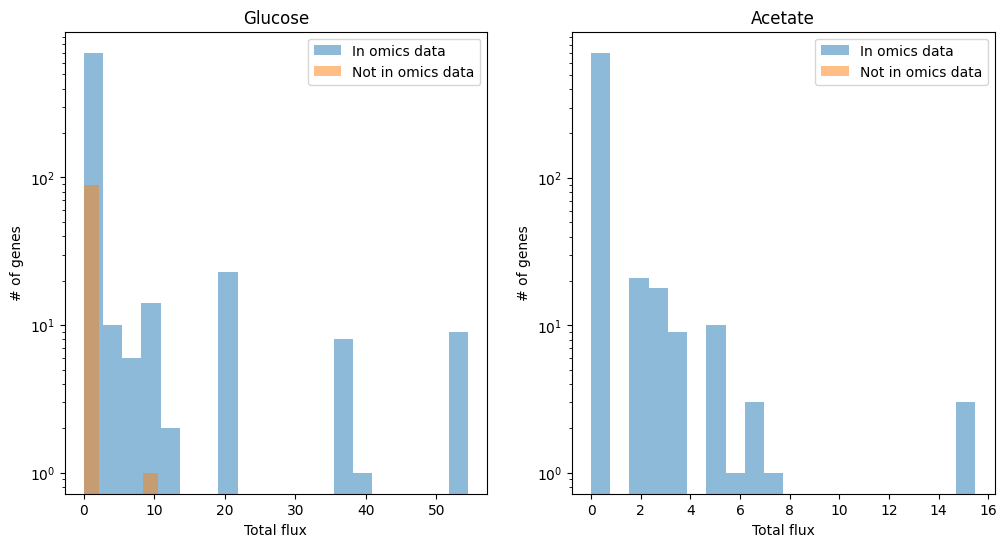

In [203]:
# Plot histograms of fluxes for genes in data and not in data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


ax1.hist([sum([abs(glc_flux[rxn.id]) for rxn in gene.reactions]) for gene in in_data],
         bins=20,
         alpha=0.5,
         label="In omics data")
ax1.hist([sum([abs(glc_flux[rxn.id]) for rxn in gene.reactions]) for gene in not_in_data],
         bins=5,
         alpha=0.5,
         label="Not in omics data")
ax1.set_ylabel("# of genes")
ax1.set_xlabel("Total flux")
ax1.set_title("Glucose")
ax1.set_yscale("log")
ax1.legend()

ax2.hist([sum([abs(ace_flux[rxn.id]) for rxn in gene.reactions]) for gene in in_data],
         bins=20,
         alpha=0.5,
         label="In omics data")
ax2.hist([sum([abs(ace_flux[rxn.id]) for rxn in gene.reactions]) for gene in not_in_data],
         bins=5,
         alpha=0.5,
         label="Not in omics data")
ax2.set_ylabel("# of genes")
ax2.set_xlabel("Total flux")
ax2.set_title("Acetate")
ax2.set_yscale("log")
ax2.legend()

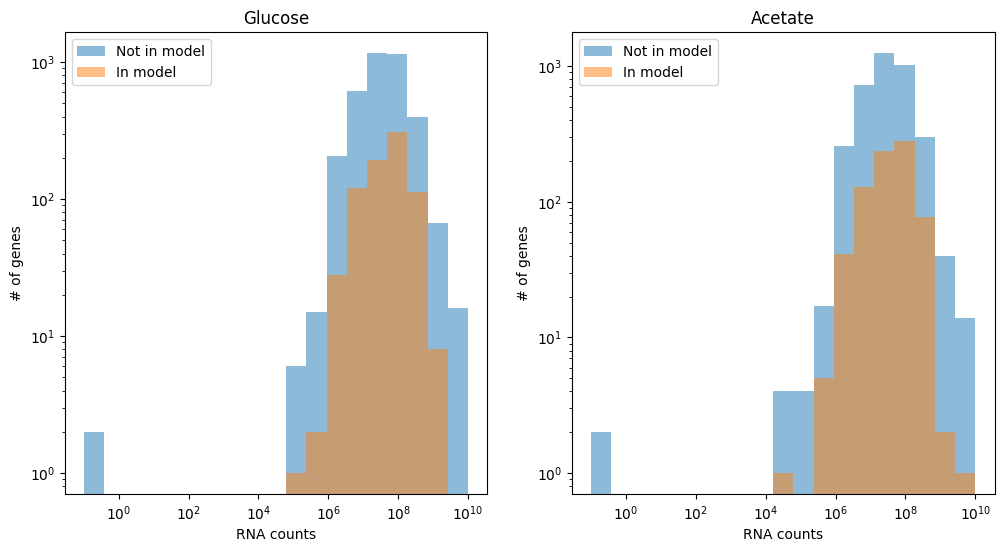

In [239]:
# Plot histograms of rna counts for genes in model and not in model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

model_gene_ids = set([gene.id for gene in model.genes])

not_in_model = []
for row in rna_abs.itertuples():
    if row.frame_id not in model_gene_ids:
        not_in_model.append(row.gene_callers_id)

ax1.hist([rna_abs["DSS3_glc_mean_abund"][rna_abs["gene_callers_id"] == gene].values[0] + 0.1 for gene in not_in_model],
         bins=np.logspace(-1, 10, 20),
         alpha=0.5,
         label="Not in model")
ax1.hist([rna_abs["DSS3_glc_mean_abund"][(rna_abs["frame_id"] == gene.id) | (rna_abs["SPO_ID (ACCESSION)"] == gene.id)].values[0] + 0.1 for gene in in_data],
         bins=np.logspace(-1, 10, 20),
         alpha=0.5,
         label="In model")
ax1.set_ylabel("# of genes")
ax1.set_xlabel("RNA counts")
ax1.set_title("Glucose")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.legend()

ax2.hist([rna_abs["DSS3_ac_mean_abund"][rna_abs["gene_callers_id"] == gene].values[0] + 0.1 for gene in not_in_model],
         bins=np.logspace(-1, 10, 20),
         alpha=0.5,
         label="Not in model")
ax2.hist([rna_abs["DSS3_ac_mean_abund"][(rna_abs["frame_id"] == gene.id) | (rna_abs["SPO_ID (ACCESSION)"] == gene.id)].values[0] + 0.1 for gene in in_data],
         bins=np.logspace(-1, 10, 20),
         alpha=0.5,
         label="In model")
ax2.set_ylabel("# of genes")
ax2.set_xlabel("RNA counts")
ax2.set_title("Acetate")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.legend()

In [205]:
model.reactions.get_by_id("O2tpp")

Reaction identifier,O2tpp
Name,O2tpp
Memory address,0x7f402610dac0
Stoichiometry,OXYGEN-MOLECULE[p] <=> OXYGEN-MOLECULE[c] oxygen <=> oxygen
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [206]:
model.metabolites.get_by_id("OXYGEN-MOLECULE[p]").reactions

frozenset({<Reaction O2tex at 0x7f402610d5b0>,
           <Reaction O2tpp at 0x7f402610dac0>})

In [207]:
# List genes not in the data with nonzero flux on glucose, acetate

purple = '\033[35m'
red = '\033[31m'
orange = '\033[33m'
yellow = '\033[93m'
ENDCOL = '\033[0m'

flux_thresholds = [0.1, 1, 10, np.inf]
flux_colors = [yellow, orange, red, purple]

print("Genes not in data with nonzero flux on glucose:")
for gene in not_in_data:
    total_flux = sum([abs(glc_flux[rxn.id]) for rxn in gene.reactions])
    color = flux_colors[np.where(total_flux < flux_thresholds)[0][0]]

    if total_flux > 0:
        print(f"{color}{gene.id} (total flux = {total_flux:.2g}){ENDCOL}")
        for reaction in gene.reactions:
            col = '\033[90m' if glc_flux[reaction.id] == 0 else ''
            endcol = '\033[0m' if glc_flux[reaction.id] == 0 else ''
            print(f"\t{col}{reaction.id}: {glc_flux[reaction.id]:.2g}{endcol}")

print("===============================================")
print("Genes not in data with nonzero flux on acetate:")
for gene in not_in_data:
    total_flux = sum([abs(ace_flux[rxn.id]) for rxn in gene.reactions])
    color = flux_colors[np.where(total_flux < flux_thresholds)[0][0]]

    if total_flux > 0:
        print(f"{color}{gene.id} (total flux = {total_flux:.2g}){ENDCOL}")
        for reaction in gene.reactions:
            col = '\033[90m' if ace_flux[reaction.id] == 0 else ''
            endcol = '\033[0m' if ace_flux[reaction.id] == 0 else ''
            print(f"\t{col}{reaction.id}: {ace_flux[reaction.id]:.2g}{endcol}")

Genes not in data with nonzero flux on glucose:
G1RHL-1790 (total flux = 0.18)
	RXN-17788: 0
	RXN-17792: 0
	RXN-14131: 0
	RXN-17796: 0
	LONG-CHAIN-ACYL-COA-DEHYDROGENASE-RXN-PALMITYL-COA/ETF-Oxidized/PROTON//CPD0-2117/ETF-Reduced.56.: 0.18
	RXN-17784: 0
SPO_RS01365 (total flux = 0.0011)
	LUMAZINESYN-RXN: 0.0011
G1RHL-1999 (total flux = 0.0057)
	RXN-17897: -0.0057
G1RHL-3135 (total flux = 10)
	RXN1RHL-6: 10
Genes not in data with nonzero flux on acetate:
G1RHL-2581 (total flux = 6.9e-14)
	DIMETHYLGLYCINE-DEHYDROGENASE-RXN: -6.9e-14
G1RHL-1790 (total flux = 0.015)
	RXN-17788: 0
	RXN-17792: 0
	RXN-14131: 0
	RXN-17796: 0
	LONG-CHAIN-ACYL-COA-DEHYDROGENASE-RXN-PALMITYL-COA/ETF-Oxidized/PROTON//CPD0-2117/ETF-Reduced.56.: 0.015
	RXN-17784: 0
SPO_RS01365 (total flux = 9e-05)
	LUMAZINESYN-RXN: 9e-05
G1RHL-3161 (total flux = 3.2e-33)
	RXN0-7248: 0
	RXN-12746: 0
	RXN-16389: 0
	RXN66-480: 0
	RXN-12702: 0
	RXN0-7239: 0
	RXN-13290: 0
	RXN66-484: 0
	TRANS-RXN0-623-DODECANOATE/ATP/CO-A/PROTON//LAUROYL

Text(0, 0.5, 'RNA abundance')

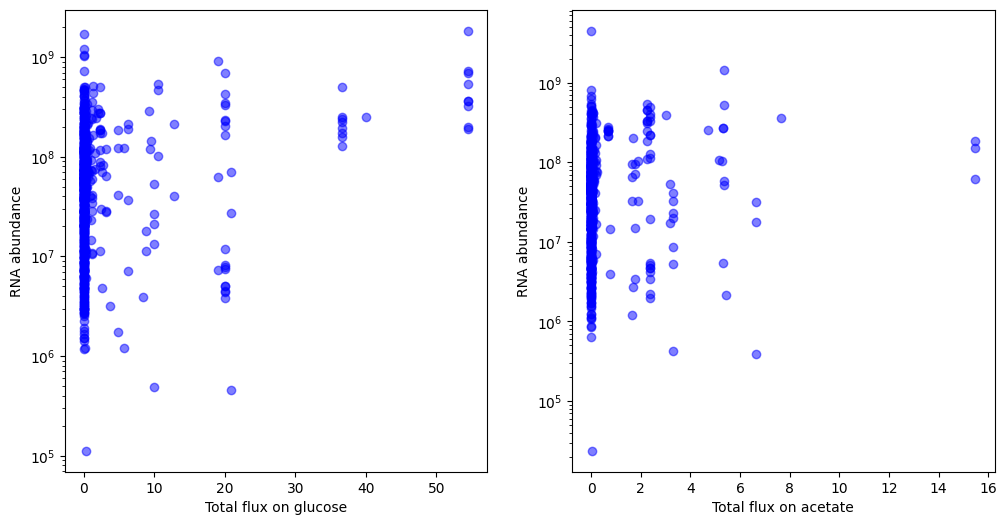

In [208]:
# Okay, now that that's out of the way, let's plot fluxes against omics data
# for genes in the data.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for gene in in_data:
    rna_abs_val_glc = rna_abs["DSS3_glc_mean_abund"][(rna_abs["frame_id"] == gene.id) | (rna_abs["SPO_ID (ACCESSION)"] == gene.id)].values[0] + 1e-12
    total_flux_glc = sum([abs(glc_flux[rxn.id]) for rxn in gene.reactions])
    ax1.scatter(total_flux_glc, rna_abs_val_glc, color="blue", alpha=0.5)

    rna_abs_val_ace = rna_abs["DSS3_ac_mean_abund"][(rna_abs["frame_id"] == gene.id) | (rna_abs["SPO_ID (ACCESSION)"] == gene.id)].values[0] + 1e-12
    total_flux_ace = sum([abs(ace_flux[rxn.id]) for rxn in gene.reactions])
    ax2.scatter(total_flux_ace, rna_abs_val_ace, color="blue", alpha=0.5)

ax1.set_yscale("log")
ax1.set_xlabel("Total flux on glucose")
ax1.set_ylabel("RNA abundance")

ax2.set_yscale("log")
ax2.set_xlabel("Total flux on acetate")
ax2.set_ylabel("RNA abundance")

## Takeaways

I found several genes that are in the model but not in the data, that have nonzero (and sometimes relatively high) flux. These point to curation issues, and I've made a spreadsheet to start addressing them (https://docs.google.com/spreadsheets/d/1ojClm3qgfE0L2SwqKbQs9RHF0naSBPyA3coGFRxcjPo/edit?gid=0#gid=0). 

However, I failed to identify genes in the model with high flux and low expression. This is because *of the genes that are in the model*, ***none of them are lowly-expressed.***

This points at a deeper issue: that **not enough reactions are annotated with their appropriate genes.**

To address this, I should:

- look at reactions without genes, e.g. in a spreadsheet ranked by flux
- look at high-abundance transcripts with no model genes
- ???


In [209]:
glc_df = glc_flux.reset_index()
glc_df["abs(flux)"] = glc_df["fluxes"].abs()
glc_df["n_genes"] = [len(model.reactions.get_by_id(rxn).genes)
                     for rxn in glc_df["index"]]
glc_df["Exchange?"] = [rxn in model.exchanges for rxn in glc_df["index"]]
glc_df["Transport?"] = [rxn.endswith("tpp") or rxn.endswith(
    "tex") for rxn in glc_df["index"]]

glc_df_filtered = glc_df[(glc_df["n_genes"] == 0)
                         & (~glc_df["Exchange?"])
                         & (~glc_df["Transport?"])].sort_values(by="abs(flux)", ascending=False)

ace_df = ace_flux.reset_index()
ace_df["abs(flux)"] = ace_df["fluxes"].abs()
ace_df["n_genes"] = [len(model.reactions.get_by_id(rxn).genes)
                     for rxn in ace_df["index"]]
ace_df["Exchange?"] = [rxn in model.exchanges for rxn in ace_df["index"]]
ace_df["Transport?"] = [rxn.endswith("tpp") or rxn.endswith(
    "tex") for rxn in ace_df["index"]]

ace_df_filtered = ace_df[(ace_df["n_genes"] == 0)
                         & (~ace_df["Exchange?"])
                         & (~ace_df["Transport?"])].sort_values(by="abs(flux)", ascending=False)

rxns_without_genes_df = pd.merge(
    glc_df_filtered[["index", "abs(flux)"]],
    ace_df_filtered[["index", "abs(flux)"]],
    on="index",
    suffixes=("_glc", "_ace")
).sort_values(
    by=["abs(flux)_glc", "abs(flux)_ace"],
    ascending=[False, False]
)

rxns_without_genes_df["Reaction"] = rxns_without_genes_df["index"].apply(
    lambda x: model.reactions.get_by_id(x).reaction
)

rxns_without_genes_df

,index,abs(flux)_glc,abs(flux)_ace,Reaction
0,PDH,9.708118,2.931083,CO-A[c] + NAD[c] + PYRUVATE[c] --> ACETYL-COA[...
1,6PFRUCTPHOS-RXN,9.600529,0.000000,ATP[c] + FRUCTOSE-6P[c] --> ADP[c] + FRUCTOSE-...
2,RXN-14970,3.100138,5.370632,CPD-9958[c] + FUM[c] <-- SUC[c] + UBIQUINONE-1...
3,RXN-16012,3.099552,5.370582,CPD-17259[c] + WATER[c] <=> CO-A[c] + MALONATE...
4,RXN-6383,3.099552,5.370582,3-HYDROXY-PROPIONYL-COA[c] <=> ACRYLYL-COA[c] ...
...,...,...,...,...
462,RXN-14503,0.000000,0.000000,CPD-15377[c] <=> D-Xylopyranose[c]
463,RXN-14396,0.000000,0.000000,HYDROXYMETHYLBILANE[c] --> CPD-11444[c] + WATE...
464,RXN-14301,0.000000,0.000000,MET[c] --> CPD-15056[c] + CPD-7671[c] + PROTON[c]
465,RXN-14290,0.000000,0.000000,2.0 CPD-12377[c] + DATP[c] --> CPD-13851[c] + ...


In [210]:
rxns_without_genes_df

,index,abs(flux)_glc,abs(flux)_ace,Reaction
0,PDH,9.708118,2.931083,CO-A[c] + NAD[c] + PYRUVATE[c] --> ACETYL-COA[...
1,6PFRUCTPHOS-RXN,9.600529,0.000000,ATP[c] + FRUCTOSE-6P[c] --> ADP[c] + FRUCTOSE-...
2,RXN-14970,3.100138,5.370632,CPD-9958[c] + FUM[c] <-- SUC[c] + UBIQUINONE-1...
3,RXN-16012,3.099552,5.370582,CPD-17259[c] + WATER[c] <=> CO-A[c] + MALONATE...
4,RXN-6383,3.099552,5.370582,3-HYDROXY-PROPIONYL-COA[c] <=> ACRYLYL-COA[c] ...
...,...,...,...,...
462,RXN-14503,0.000000,0.000000,CPD-15377[c] <=> D-Xylopyranose[c]
463,RXN-14396,0.000000,0.000000,HYDROXYMETHYLBILANE[c] --> CPD-11444[c] + WATE...
464,RXN-14301,0.000000,0.000000,MET[c] --> CPD-15056[c] + CPD-7671[c] + PROTON[c]
465,RXN-14290,0.000000,0.000000,2.0 CPD-12377[c] + DATP[c] --> CPD-13851[c] + ...


In [211]:
rxns_without_genes_df.head(100).to_clipboard(index=False)

Now, high-abundance transcripts without model genes / low flux:

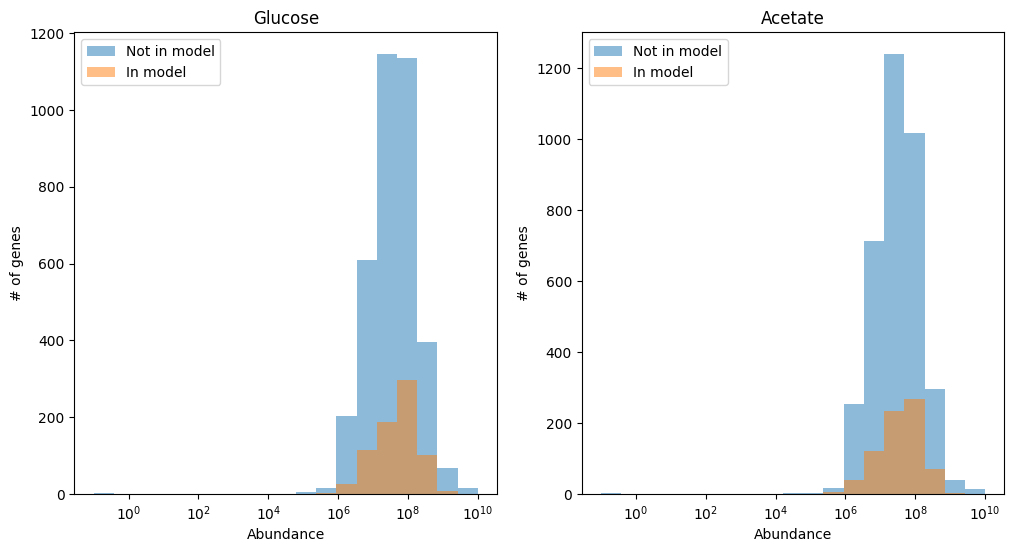

In [ ]:
# Find and plot genes in the data that are not in the model

transcripts_with_model_genes = []
transcripts_without_model_genes = []
for _, row in rna_abs.iterrows():
    if row.frame_id not in model_gene_ids and row["SPO_ID (ACCESSION)"] not in model_gene_ids:
        transcripts_without_model_genes.append(row["gene_callers_id"])
    else:
        transcripts_with_model_genes.append(row["gene_callers_id"])

# Plot histograms of RNA abundance for transcripts with and without model genes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist([rna_abs["DSS3_glc_mean_abund"][rna_abs["gene_callers_id"] == gene].values[0] + 0.1 for gene in transcripts_without_model_genes],
         bins=np.logspace(-1, 10, 20),
         alpha=0.5,
         label="Not in model")
ax1.hist([rna_abs["DSS3_glc_mean_abund"][rna_abs["gene_callers_id"] == gene].values[0] + 0.1 for gene in transcripts_with_model_genes],
            bins=np.logspace(-1, 10, 20),
            alpha=0.5,
            label="In model")

ax1.set_xscale("log")
ax1.set_xlabel("Abundance")
ax1.set_ylabel("# of genes")
ax1.set_title("Glucose")
ax1.legend()

ax2.hist([rna_abs["DSS3_ac_mean_abund"][rna_abs["gene_callers_id"] == gene].values[0] + 0.1 for gene in transcripts_without_model_genes],
         bins=np.logspace(-1, 10, 20),
         alpha=0.5,
         label="Not in model")
ax2.hist([rna_abs["DSS3_ac_mean_abund"][rna_abs["gene_callers_id"] == gene].values[0] + 0.1 for gene in transcripts_with_model_genes],
            bins=np.logspace(-1, 10, 20),
            alpha=0.5,
            label="In model")

ax2.set_xscale("log")
ax2.set_xlabel("Abundance")
ax2.set_ylabel("# of genes")
ax2.set_title("Acetate")
ax2.legend()


In [253]:
# Pick out the top 100 genes under each condition with no model equivalent

top_transcripts_without_model_equiv_glc = rna_abs[
    [gene in transcripts_without_model_genes
     for gene in rna_abs["gene_callers_id"]]
].sort_values(by="DSS3_glc_mean_abund",
              ascending=False).head(100)

top_transcripts_without_model_equiv_ace = rna_abs[
    [gene in transcripts_without_model_genes
     for gene in rna_abs["gene_callers_id"]]
].sort_values(by="DSS3_ac_mean_abund",
              ascending=False).head(100)

# Merge
top_transcripts_without_model_equiv = rna_abs[
    [gene in top_transcripts_without_model_equiv_glc["gene_callers_id"].values
     or gene in top_transcripts_without_model_equiv_ace["gene_callers_id"].values
        for gene in rna_abs["gene_callers_id"]]
].sort_values(
    by=["DSS3_glc_mean_abund", "DSS3_ac_mean_abund"],
    ascending=[False, False]
)

top_transcripts_without_model_equiv.head(100)

,Rank,gene_callers_id,DSS3_ac_mean_abund,DSS3_glc_mean_abund,DSS3_late_mean_abund,DSS3_early_mean_abund,DSS3_ac_v_DSS3_glc_FOLD_CHANGE_rna,DSS3_ac_v_DSS3_late_FOLD_CHANGE_rna,DSS3_ac_v_DSS3_early_FOLD_CHANGE_rna,DSS3_glc_v_DSS3_late_FOLD_CHANGE_rna,...,DSS3_glc_v_DSS3_early_Tukey_HSD_adjusted_p,DSS3_late_v_DSS3_early_Tukey_HSD_adjusted_p,SPO_ID (ACCESSION),KOfam (ACCESSION),KEGG_Module,COG20_FUNCTION,n_matches,frame_id,n_reactions,reaction_ids
654,655,2962,9.186001e+09,1.768416e+10,1.722574e+10,3.112637e+10,-0.940015,-0.898108,-1.722945,0.041906,...,NaN,NaN,SPO_SprnpB1,NaN,NaN,NaN,1,SPO_RS22335,0.0,None
411,412,2137,3.042165e+09,1.392971e+10,1.132049e+10,1.775651e+10,-2.204364,-1.906894,-2.510797,0.297471,...,NaN,NaN,SPO2135,NaN,NaN,NaN,1,SPO_RS10825,0.0,None
600,601,3261,6.133739e+09,1.297984e+10,1.006293e+10,1.879794e+10,-1.075660,-0.705243,-1.589048,0.370417,...,NaN,NaN,SPO_Sp5SE,NaN,NaN,NaN,1,SPO_RS16535,0.0,None
1191,1192,1911,6.479695e+09,1.202042e+10,1.201603e+10,1.924317e+10,-0.887396,-0.883546,-1.532403,0.003850,...,NaN,NaN,SPO_SptmRNA1,NaN,NaN,NaN,1,SPO_RS22505,0.0,None
2166,2167,227,4.218669e+09,1.032040e+10,1.011725e+10,8.698376e+09,-1.302269,-1.273337,-1.008621,0.028931,...,NaN,NaN,SPO0229,K02970,NaN,Ribosomal protein S21 (RpsU) (PDB:4V4H),1,SPO_RS01170,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,985,3107,1.343170e+08,6.575797e+08,5.056026e+08,7.868549e+08,-2.302460,-1.919001,-2.497927,0.383459,...,NaN,NaN,SPO3111,K03560,NaN,Biopolymer transport protein ExbD (ExbD) (PDB:...,1,SPO_RS15765,0.0,None
1053,1054,2987,3.072194e+07,6.438806e+08,9.532685e+07,1.125078e+08,-4.292646,-1.624995,-1.808115,2.667651,...,NaN,NaN,SPO3904,K13993,NaN,"Small heat shock protein IbpA, HSP20 family (I...",1,SPO_RS15160,0.0,None
581,582,1992,5.856551e+08,6.397836e+08,4.434479e+08,1.653125e+09,-0.124365,0.401616,-1.436685,0.525981,...,NaN,NaN,SPO1990,K02888,NaN,Ribosomal protein L21 (RplU) (PDB:1VS6)!!!Pred...,1,SPO_RS10095,0.0,None
220,221,862,1.405504e+07,6.384962e+08,4.429479e+08,5.639918e+08,-5.522895,-4.996979,-5.276616,0.525916,...,NaN,NaN,SPO0863,K10545,NaN,"ABC-type sugar transport system, ATPase compon...",1,SPO_RS04350,0.0,None


In [254]:
top_transcripts_without_model_equiv[[
    "gene_callers_id",
    "DSS3_ac_mean_abund",
    "DSS3_glc_mean_abund",
    "SPO_ID (ACCESSION)",
    "KOfam (ACCESSION)",
    "KEGG_Module",
    "COG20_FUNCTION",
    "n_matches",
    "frame_id",
    "n_reactions",
    "reaction_ids"
]].head(200).to_clipboard(index=False)